Домашнее задание
Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

### взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

возьму тот же датасет, что и для прошлого занятия (Adults) https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

In [5]:
import pandas as pd
import numpy as np

In [6]:
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
            'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
target = 'income'

data = pd.read_csv('adult.data', sep=',', index_col=False, names=features + [target])

### сделать обзорный анализ выбранного датасета

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
#наличие пропусков (пропусков нет)
pd.DataFrame([data.isna().sum(), data.isnull().sum()], index={'na', 'null'})

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
na,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

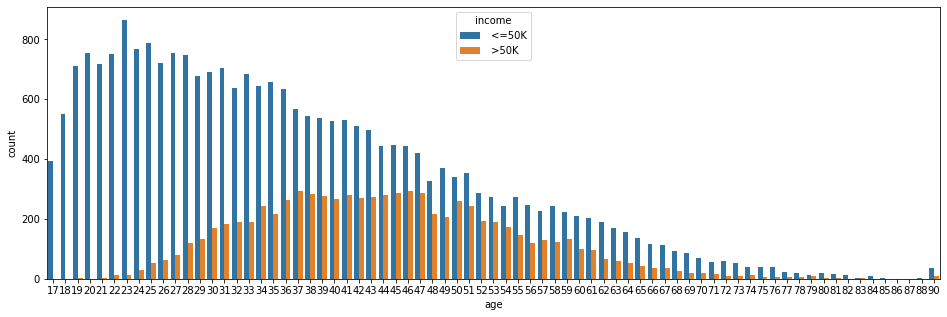

In [11]:
plt.figure(figsize=(16, 5))
sns.countplot(data=data, x='age', hue='income');

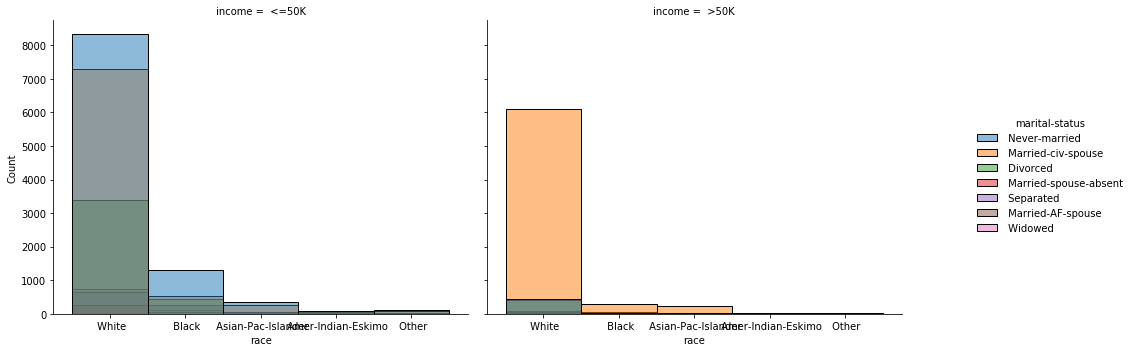

In [15]:
g = sns.displot(data=data, x="race", hue='marital-status', col='income', kind='hist')
g.fig.set_size_inches(16, 5)

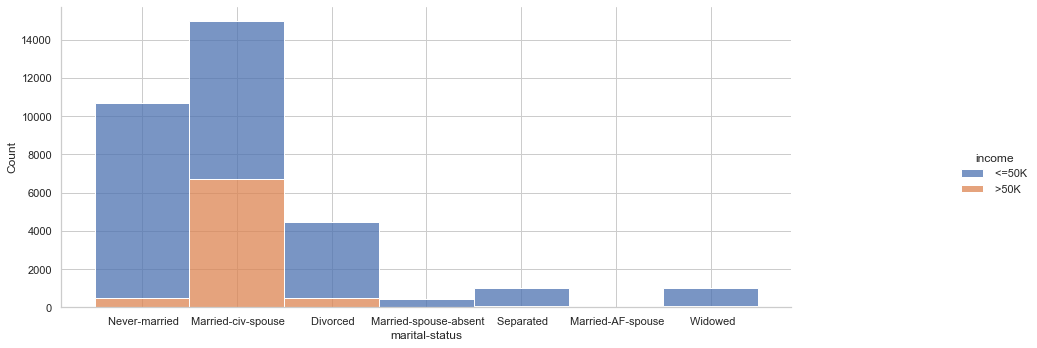

In [16]:
sns.set_theme(style="whitegrid")
b = sns.displot(data=data,
                x="marital-status",
                multiple='stack',
                hue='income')
b.fig.set_size_inches(16, 5)

### сделать feature engineering

In [18]:
data['income'] = data['income'].map({' <=50K': 0, ' >50K': 1})

In [19]:
data.rename(columns={'native-country': 'from_USA'}, inplace=True)

In [20]:
data['from_USA'] = data['from_USA'].apply(lambda x: 1 if x == ' United-States' else 0)

In [21]:
data['sex'] = data['sex'].map({' Male': 1, ' Female': 0})

In [22]:
data['race'] = data['race'].apply(lambda x: 1 if x == ' White' else 0)
data.rename(columns={'race': 'white'}, inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(data.drop('income', axis=1))
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### обучить любой классификатор (какой вам нравится)

In [27]:
%%time
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

[22:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1.59 s


In [26]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
def results_evaluation(y_test, y_predict):
    """ Проверка качества модели с помощью DS-метрик"""
    from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

    return pd.DataFrame(
        [{
            'f1': f1_score(y_test, y_predict),
            'precision': precision_score(y_test, y_predict, average='binary'),
            'recall': recall_score(y_test, y_predict, average='binary'),
            'roc': roc_auc_score(y_test, y_predict),
        }],
        index={'metrics'}).round(3)


results_evaluation(y_test, y_predict)

,f1,precision,recall,roc
metrics,0.705,0.763,0.655,0.795


### разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [29]:
import shap

In [33]:
%%time

model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

Wall time: 7.33 s


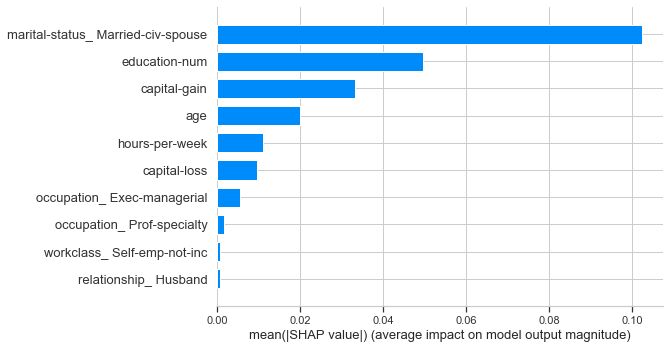

In [36]:
shap.summary_plot(shap_values=shap_values, features=X_train, plot_type='bar', max_display=10)

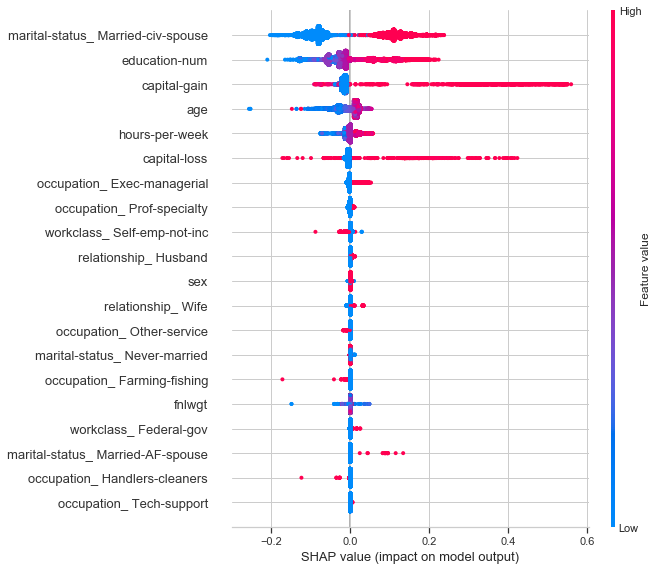

In [37]:
shap.summary_plot(shap_values, X_train)

Видно, что наибольший вес имеет семейное положение (состоит ли в браке), в данном случае именно женатые или состоящие в гражданском браке имеют наибольший шанс на годовой доход свыше 50К. А такой, на первый взгляд важный показатель, как возраст находится на 4м месте по важности.  

In [46]:
def force_plot(sample_number):
    display(
        pd.DataFrame(data.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], X_train.iloc[sample_number, :]))

force_plot(sample_number=0)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,white,sex,capital-gain,capital-loss,hours-per-week,from_USA,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,1,1,2174,0,40,1,0


для первого наблюдения наибольший вес имеют следующие показатели: martial status, capital loss, education num, hourse per week